In [1]:
# 導入必要的庫
import os
import numpy as np
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter, defaultdict
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D, Add, Activation
from tensorflow.keras.utils import to_categorical
import seaborn as sns
%matplotlib inline


c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf

print("TensorFlow 版本:", tf.__version__)
print("GPU 可用:", tf.config.list_physical_devices('GPU'))




TensorFlow 版本: 2.17.0
GPU 可用: []


In [3]:
# 定義資料目錄
data_dir = 'split05/'  # 替換為您的數據目錄

# 定義類別和對應的標籤
categories = {'non': 0, 'swallow': 1}

# 列出所有音頻文件及其標籤
audio_files = []
labels = []

for category, label in categories.items():
    category_dir = os.path.join(data_dir, category)
    if not os.path.exists(category_dir):
        print(f"目錄 {category_dir} 不存在。請確認路徑正確。")
        continue
    for file in os.listdir(category_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(category_dir, file)
            audio_files.append(file_path)
            labels.append(label)

print(f"總音頻文件數量: {len(audio_files)}")
print(f"標籤分佈: {Counter(labels)} (非吞嚥: {categories['non']}, 吞嚥: {categories['swallow']})")


總音頻文件數量: 112
標籤分佈: Counter({0: 63, 1: 49}) (非吞嚥: 0, 吞嚥: 1)


In [6]:
# 定義音頻處理函數
def load_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def reduce_noise_signal(y, sr):
    if len(y) < int(0.5 * sr):
        noise_sample = y
    else:
        noise_sample = y[:int(0.5 * sr)]
    y_reduced = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)
    return y_reduced

def split_audio(y, sr, segment_length, hop_length):
    segment_samples = int(segment_length * sr)
    hop_samples = int(hop_length * sr)
    segments = []
    num_segments = 0

    for start in range(0, len(y) - segment_samples + 1, hop_samples):
        end = start + segment_samples
        segments.append(y[start:end])
        num_segments += 1

    # 處理最後一個不足長度的片段
    remaining_samples = len(y) - (num_segments * hop_samples)
    if remaining_samples > 0 and remaining_samples < segment_samples:
        last_segment = y[-segment_samples:]
        padding = segment_samples - len(last_segment)
        last_segment_padded = np.pad(last_segment, (0, padding), mode='constant')
        segments.append(last_segment_padded)

    return segments

def extract_features(y, sr, n_mels=128, n_fft=2048, hop_length=512, fixed_length=130):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                              n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # 固定長度
    mel_spec_db = librosa.util.fix_length(mel_spec_db, size=fixed_length, axis=1)

    return mel_spec_db


In [7]:
# 初始化特徵和標籤列表
features = []
labels_processed = []

# 計數每個類別的片段數量
segment_counts = defaultdict(int)

# 定義固定的時間步數
fixed_length = 130

# 迭代處理每個音頻文件
for file_path, label in zip(audio_files, labels):
    # 讀取音頻
    y, sr = load_audio(file_path)

    # 去噪（可選）
    y = reduce_noise_signal(y, sr)

    # 分割音頻
    segments = split_audio(y, sr, segment_length=0.5, hop_length=0.25)

    # 如果分割後沒有片段，跳過該文件
    if not segments:
        continue

    # 對每個片段提取特徵
    for segment in segments:
        mel_spec = extract_features(segment, sr, fixed_length=fixed_length)
        mel_spec = mel_spec[..., np.newaxis]  # 添加channel維度 (128, 130, 1)
        features.append(mel_spec)
        labels_processed.append(label)
        segment_counts[label] += 1

print(f"總片段數量: {len(features)}")
print("每個類別的片段數量:", dict(segment_counts))
# 檢查所有特徵的形狀是否一致
for i, feature in enumerate(features):
    if feature.shape != (128, fixed_length, 1):
        print(f"片段 {i} 的形狀不一致: {feature.shape}")



總片段數量: 242
每個類別的片段數量: {0: 146, 1: 96}


In [8]:
# 將特徵和標籤轉換為NumPy數組
X = np.array(features)
y = np.array(labels_processed)
print(f"特徵形狀: {X.shape}")  # 應為 (samples, 128, 130, 1)
print(f"標籤形狀: {y.shape}")

# 將數值標準化到0-1之間
X = X / np.max(X)
print(f"標準化後的特徵形狀: {X.shape}")

# 調整數據形狀為 (samples, height, width, channels)
# 這裡將保持高度=128, 寬度=130, channels=1
# ResNet 在 Keras 中需要 (height, width, channels)
print("原始X形狀:", X.shape)

# 分割訓練集和測試集
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    print(f"訓練集大小: {X_train.shape}")
    print(f"測試集大小: {X_test.shape}")
except ValueError as e:
    print("分層抽樣失敗，嘗試不使用 stratify")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"訓練集大小: {X_train.shape}")
    print(f"測試集大小: {X_test.shape}")

# 將標籤轉為類別
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(f"訓練集標籤形狀: {y_train.shape}")
print(f"測試集標籤形狀: {y_test.shape}")

# 確保 y_train_labels 是一維的
y_train_labels = np.argmax(y_train, axis=1).astype(int).flatten()

print("y_train_labels shape:", y_train_labels.shape)  # 應為 (n_samples,)
print("y_train_labels:", y_train_labels[:10])  # 應為 [0, 1, 0, 0, ...]

# 獲取唯一類別
classes = np.unique(y_train_labels)
print("唯一類別:", classes)

# 計算類別權重
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels)
class_weights_dict = {i: weight for i, weight in zip(classes, class_weights)}
print("類別權重:", class_weights_dict)



特徵形狀: (242, 128, 130, 1)
標籤形狀: (242,)
標準化後的特徵形狀: (242, 128, 130, 1)
原始X形狀: (242, 128, 130, 1)
訓練集大小: (193, 128, 130, 1)
測試集大小: (49, 128, 130, 1)
訓練集標籤形狀: (193, 2)
測試集標籤形狀: (49, 2)
y_train_labels shape: (193,)
y_train_labels: [0 0 1 0 0 1 1 1 1 1]
唯一類別: [0 1]
類別權重: {0: 0.8318965517241379, 1: 1.2532467532467533}


In [9]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """A residual block.
    
    Arguments:
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, the kernel size of middle conv layer at main path.
        stride: default 1, stride of the first layer in the block.
        conv_shortcut: default True, whether to use a convolutional layer to match dimensions.
        name: string, block label.
    
    Returns:
        Output tensor for the block.
    """
    bn_axis = 3  # Channels last

    shortcut = x
    if conv_shortcut:
        # 修改這裡，將 filters 改為 4 * filters
        shortcut = Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(shortcut)
    
    # 主路徑
    x = Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = Activation('relu', name=name + '_1_relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same', name=name + '_2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = Activation('relu', name=name + '_2_relu')(x)
    
    x = Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)
    
    # 調試信息：打印主路徑和捷徑路徑的形狀
    print(f"{name}_shortcut shape: {shortcut.shape}")
    print(f"{name}_main path shape: {x.shape}")
    
    x = Add(name=name + '_add')([shortcut, x])
    x = Activation('relu', name=name + '_out')(x)
    return x

def build_resnet(input_shape, num_classes=2, depth=50):
    """Builds a ResNet model.
    
    Arguments:
        input_shape: tuple, the shape of input data, e.g., (128, 130, 1)
        num_classes: integer, number of classes for classification.
        depth: integer, depth of the ResNet model.
    
    Returns:
        Keras Model instance.
    """
    if depth == 50:
        layers_config = [3, 4, 6, 3]
    elif depth == 101:
        layers_config = [3, 4, 23, 3]
    elif depth == 152:
        layers_config = [3, 8, 36, 3]
    else:
        raise ValueError("Unsupported ResNet depth: {}. Use 50, 101, or 152.".format(depth))
    
    bn_axis = 3  # Channels last

    inputs = Input(shape=input_shape, name='input')

    # Initial convolution and max-pooling
    x = Conv2D(64, 7, strides=1, padding='same', name='conv1_conv')(inputs)  # stride 改為 1
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='pool1_pool')(x)

    # Residual blocks
    filters = 64
    for stage, blocks in enumerate(layers_config):
        for block in range(blocks):
            if block == 0:
                if stage != 0:
                    stride = 2
                else:
                    stride = 1
                conv_shortcut = True
            else:
                stride = 1
                conv_shortcut = False
            x = residual_block(
                x, 
                filters, 
                stride=stride, 
                conv_shortcut=conv_shortcut, 
                name='conv{}_block{}'.format(stage + 2, block + 1)
            )
        filters *= 2

    # Global Average Pooling and output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(num_classes, activation='softmax', name='fc')(x)

    model = Model(inputs, x, name='resnet{}'.format(depth))
    return model

# 獲取輸入形狀
input_shape = X_train.shape[1:]  # 假設形狀為 (128, 130, 1)
print("輸入形狀:", input_shape)

# 建立 ResNet50 模型
model = build_resnet(input_shape=input_shape, num_classes=2, depth=50)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


輸入形狀: (128, 130, 1)
conv2_block1_shortcut shape: (None, 64, 65, 256)
conv2_block1_main path shape: (None, 64, 65, 256)
conv2_block2_shortcut shape: (None, 64, 65, 256)
conv2_block2_main path shape: (None, 64, 65, 256)
conv2_block3_shortcut shape: (None, 64, 65, 256)
conv2_block3_main path shape: (None, 64, 65, 256)
conv3_block1_shortcut shape: (None, 32, 33, 512)
conv3_block1_main path shape: (None, 32, 33, 512)
conv3_block2_shortcut shape: (None, 32, 33, 512)
conv3_block2_main path shape: (None, 32, 33, 512)
conv3_block3_shortcut shape: (None, 32, 33, 512)
conv3_block3_main path shape: (None, 32, 33, 512)
conv3_block4_shortcut shape: (None, 32, 33, 512)
conv3_block4_main path shape: (None, 32, 33, 512)
conv4_block1_shortcut shape: (None, 16, 17, 1024)
conv4_block1_main path shape: (None, 16, 17, 1024)
conv4_block2_shortcut shape: (None, 16, 17, 1024)
conv4_block2_main path shape: (None, 16, 17, 1024)
conv4_block3_shortcut shape: (None, 16, 17, 1024)
conv4_block3_main path shape: (None

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 128, 130,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 130,  │      3,200 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 130,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 130,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 65,    │          0 │ conv1_relu[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 65,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 65,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 65,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 65,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 65,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 65,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 65,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 65,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 65,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 65,    │      1,024 │ conv2_block1_3_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_add    │ (None, 64, 65,    │          0 │ conv2_block1_0_b… │
│ (Add)               │ 256)              │            │ conv2_block1_3_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 64, 65,    │          0 │ conv2_block1_add

 Total params: 23,585,538 (89.97 MB)

 Trainable params: 23,532,418 (89.77 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.6440 - loss: 1.8531 - val_accuracy: 0.3878 - val_loss: 8246.9873
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8060 - loss: 0.5328 - val_accuracy: 0.3878 - val_loss: 3678.1899
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8451 - loss: 0.4121 - val_accuracy: 0.3878 - val_loss: 879.6460
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8053 - loss: 0.4370 - val_accuracy: 0.3878 - val_loss: 143.7063
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8646 - loss: 0.4396 - val_accuracy: 0.3878 - val_loss: 32.6551
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8247 - loss: 0.4187 - val_accuracy: 0.4286 - val_loss: 14.8922
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7919 - loss: 0.5064 - val_accuracy: 0.6122 - val_loss: 0.9399
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8081 - loss: 0.4124 - val_accuracy: 0.6122

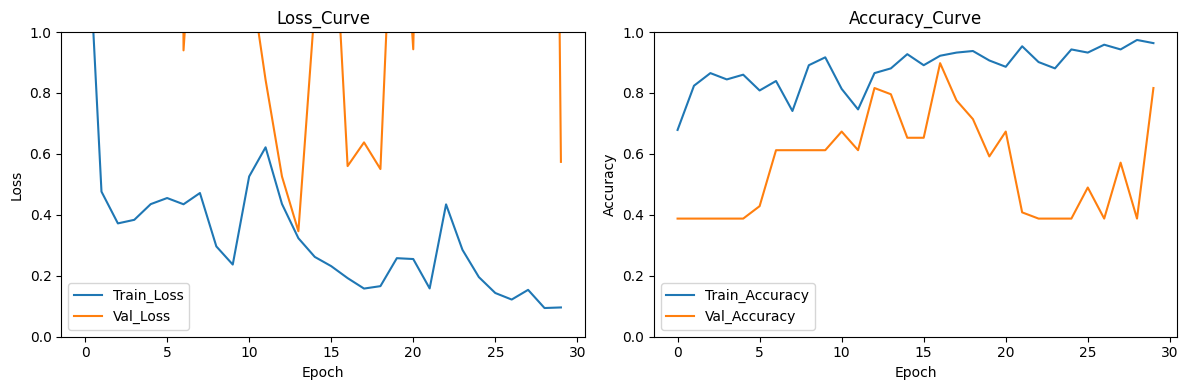

In [10]:
# 訓練模型，並使用類別權重和早停法
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)

# 繪製訓練過程
plt.figure(figsize=(12, 4))

# 繪製損失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train_Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.title('Loss_Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

# 繪製準確率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train_Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.title('Accuracy_Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# 評估模型在測試集上的表現
loss, accuracy = model.evaluate(X_test, y_test)
print(f"測試集損失: {loss:.4f}")
print(f"測試集準確率: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.8046 - loss: 0.6181
測試集損失: 0.5740
測試集準確率: 81.63%


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
混淆矩陣:
[[21  9]
 [ 0 19]]

分類報告:
              precision    recall  f1-score   support

         NON       1.00      0.70      0.82        30
     Swallow       0.68      1.00      0.81        19

    accuracy                           0.82        49
   macro avg       0.84      0.85      0.82        49
weighted avg       0.88      0.82      0.82        49



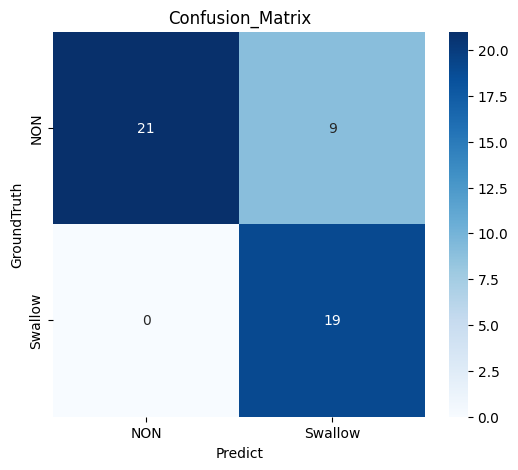

In [12]:
# 預測測試集
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred_classes)
print("混淆矩陣:")
print(cm)

# 分類報告
print("\n分類報告:")
print(classification_report(y_true, y_pred_classes, target_names=['NON', 'Swallow']))

# 可視化混淆矩陣
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NON', 'Swallow'],
            yticklabels=['NON', 'Swallow'])
plt.ylabel('GroundTruth')
plt.xlabel('Predict')
plt.title('Confusion_Matrix')
plt.show()


In [13]:
# 定義滑動窗口預測函數
def sliding_window_predict(y, sr, model, window_length=1.0, hop_length=0.5, threshold=0.5, fixed_length=130):
    """
    使用滑動窗口方法對整個音頻進行預測，並計數吞嚥聲音的數量。

    參數:
    - y: 音頻信號
    - sr: 採樣率
    - model: 已訓練的ResNet模型
    - window_length: 窗口長度（秒）
    - hop_length: 窗口跳步長度（秒）
    - threshold: 判斷為吞嚥聲音的概率閾值
    - fixed_length: 固定的時間步數（帧數）

    返回:
    - count: 吞嚥聲音的數量
    """
    window_samples = int(window_length * sr)
    hop_samples = int(hop_length * sr)
    predictions = []

    for start in range(0, len(y) - window_samples + 1, hop_samples):
        end = start + window_samples
        window = y[start:end]
        mel_spec = extract_features(window, sr, fixed_length=fixed_length)
        mel_spec = mel_spec[..., np.newaxis]  # (128, 130, 1)

        # 處理可能的NaN或極小值
        if np.max(mel_spec) == 0:
            mel_spec = mel_spec + 1e-6
        mel_spec = mel_spec / np.max(mel_spec)  # 標準化

        # 調整形狀為 (samples, height, width, channels)
        mel_spec = mel_spec.reshape(1, 128, fixed_length, 1)  # (1, 128, 130, 1)

        pred = model.predict(mel_spec, verbose=0)
        predictions.append(pred[0][1])  # 吞嚥聲音的概率

    # 根據閾值判斷吞嚥事件
    swallowing_events = [i for i, prob in enumerate(predictions) if prob > threshold]

    # 去除重疊的事件
    min_distance = int(window_length / hop_length * 1)  # 最小間隔，根據實際情況調整
    final_events = []
    last_event = -min_distance
    for event in swallowing_events:
        if event - last_event > min_distance:
            final_events.append(event)
            last_event = event

    return len(final_events)


In [14]:
# 定義新的音頻文件路徑
new_audio_path = '音檔\比較輕吞.wav'  # 替換為您的音頻文件路徑

# 檢查文件是否存在並進行預測
if not os.path.exists(new_audio_path):
    print(f"音頻文件 {new_audio_path} 不存在。請確認路徑正確。")
else:
    # 讀取新的音頻文件
    y_new, sr_new = load_audio(new_audio_path)

    # 可選：去噪
    y_new = reduce_noise_signal(y_new, sr_new)

    # 使用滑動窗口方法進行預測和計數
    count = sliding_window_predict(y_new, sr_new, model, window_length=1.0, hop_length=0.5, threshold=0.5, fixed_length=130)
    print(f"吞嚥聲音數量: {count}")


吞嚥聲音數量: 7
